In [3]:
# Required Libraries
import duckdb
import pandas
import seaborn as sns

In [13]:
# Get Manchester City's ranking week by week

database_path = '../duckdb-databases/sports_db.duckdb'
query = '''
WITH

standings_versions AS (
	SELECT * FROM dev.football_football_data__standings_versions WHERE competition_name = 'Premier League'
),

-- Week by week, how has evolved Man City's ranking this season?
-- Pour ça, on va regarder à la fin de chaque semaine. Donc, on doit prendre la derniere version d'une équipe si elle en 
-- a plusieurs pour une semaine.
-- Stratégie : dresser un classement semaine par semaine de la Premier League

weekly_calendar AS (
	SELECT DISTINCT
		week_start_date,
		week_end_date,
	FROM dev.utils__calendar
),

-- Standings at the end of each week.
weekly_rankings AS (
	SELECT
		*,
		ROW_NUMBER() OVER(PARTITION BY competition_id, week_start_date ORDER BY total_pts DESC) AS ranking,
	FROM weekly_calendar
	-- Si on veut le standings à une date d donnée, on doit prendre toutes les versions qui contiennent cette date d
	LEFT JOIN standings_versions ON weekly_calendar.week_end_date BETWEEN standings_versions.version_start_at AND standings_versions.version_end_at
	WHERE standings_versions.standings_version_id IS NOT NULL
)

SELECT 
	week_start_date,
	week_end_date,
	team_name,
	total_home_pts,
	total_away_pts,
	total_pts,
	ranking,
FROM weekly_rankings
WHERE team_name = 'Manchester City FC'
ORDER BY 1
'''

with duckdb.connect(database_path) as con:
    df = con.sql(query).df()

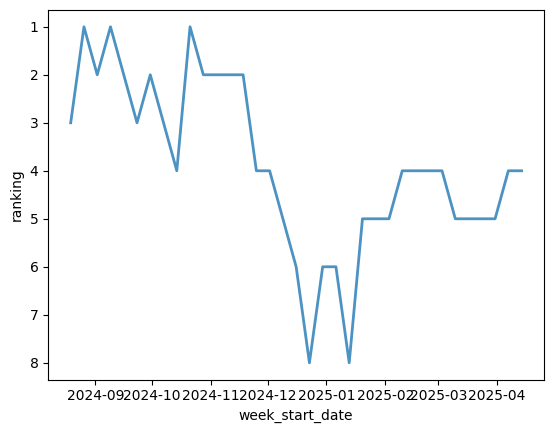

In [24]:
sns.lineplot(
    data=df,
    x='week_start_date',
    y='ranking',
    linewidth=2,
    alpha=0.8).invert_yaxis()  # Invert y-axis to show higher rankings at the top